# Getting started with the D+ API
This Jupyter notebook was written to help new users understand how to work with the API.
The reading of the documentation is still extremely recommended to really understand the inner workings.

First, we need import the basic modules which we will (almost) always need:

In [1]:
from dplus.CalculationInput import CalculationInput # To create states
from dplus.CalculationRunner import EmbeddedLocalRunner # To access the backend and run the calculation

runner = EmbeddedLocalRunner()

Now, we shall build our state, containing a sphere of radius 2nm and electron density 400

In [2]:
from dplus.DataModels.models import Sphere

Test_sphere = Sphere()
Test_sphere.layer_params[1].radius.value = 2
Test_sphere.layer_params[1].ed.value = 400

# Create a calculation state
state = CalculationInput()
state.Domain.populations[0].add_model(Test_sphere)

We note that our state is built with a lot of default values, like q_max (7.5) or grid_size.
We will change it now so that we'll calculate up to q = 10, and according to Suggest Parameters, we need a grid size of 50.
To get a good resolution, we will define 1000 calculation points, and make sure we run it on our GPU.

In [3]:
state.DomainPreferences.grid_size = 50
state.DomainPreferences.q_max = 10
state.DomainPreferences.generated_points = 1000
state.use_gpu = True

And now we run!

In [4]:
output = runner.generate(state)

Now we shall plot the result (in semi-log scale)

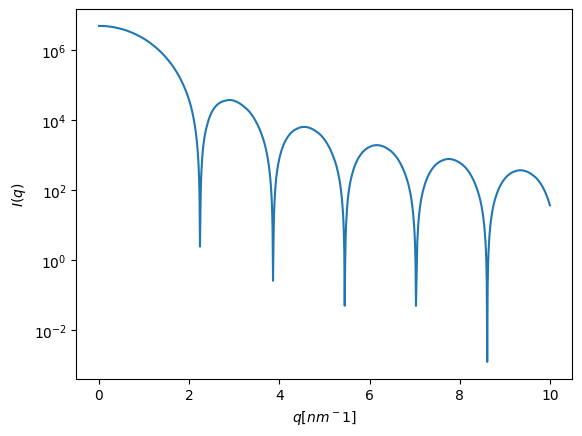

In [5]:
import matplotlib.pyplot as plt

q = list(output.graph.keys())
I_q = list(output.graph.values())

plt.semilogy(q, I_q)
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.show()

If we want to give this sphere some polydispersity and recalculate:

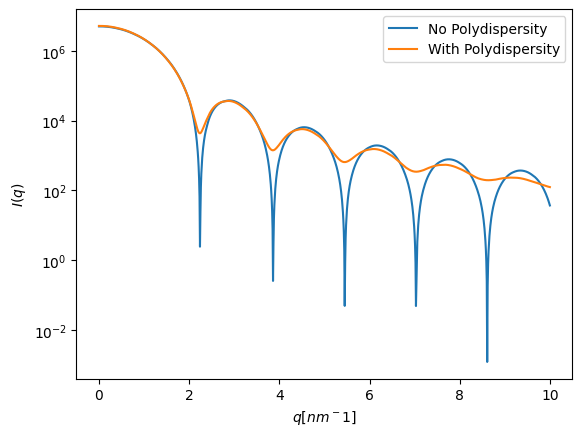

In [19]:
Test_sphere.layer_params[1].radius.sigma = .1

output_w_pd = runner.generate(state)

I_q_w_pd = list(output_w_pd.graph.values())

plt.semilogy(q, I_q, label='No Polydispersity')
plt.semilogy(q, I_q_w_pd, label='With Polydispersity')
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.legend()
plt.show()

We can also calculate the scattering in the case we have a resolution function:

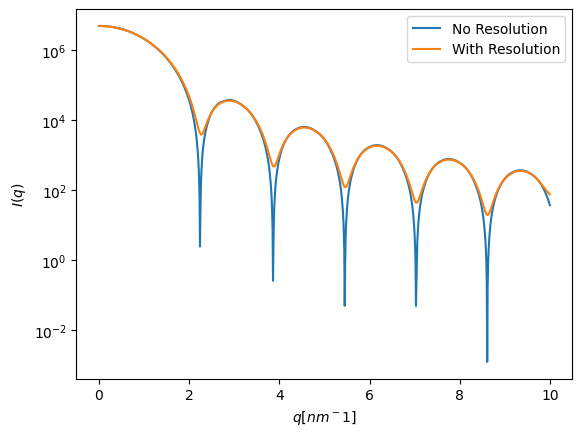

In [20]:
Test_sphere.layer_params[1].radius.sigma = 0 # Reset the polydispersity to 0

state.DomainPreferences.apply_resolution = True
state.DomainPreferences.resolution_sigma = 0.1

output_w_res = runner.generate(state)

I_q_w_res = list(output_w_res.graph.values())

plt.semilogy(q, I_q, label='No Resolution')
plt.semilogy(q, I_q_w_res, label='With Resolution')
plt.xlabel('$q [nm^-1]$')
plt.ylabel('$I(q)$')
plt.legend()
plt.show()

Let's now build to more states, one with just a PDB as model and the second one after putting this PDB inside a manual symmetry that we shall build:

In [32]:
from dplus.DataModels.models import PDB
from dplus.DataModels import ManualSymmetry
import dplus.g_r as g
import numpy as np

## Create a PDB
Test_PDB = PDB(r'../CF4.pdb')
Test_PDB.centered = True # Make sure the PDB is centered
Test_PDB.extra_params.solvent_method.value = 0

## Create a calculation state for only the PDB
state_PDB = CalculationInput()
state_PDB.Domain.populations[0].add_model(Test_PDB)
state_PDB.DomainPreferences.grid_size = 100
state_PDB.DomainPreferences.q_max = 60
state_PDB.DomainPreferences.generated_points = 10000
state_PDB.use_gpu = True

In [33]:
## Create a cubic lattice with the PDB
Test_PDB_sym = PDB(r'../CF4.pdb')
Test_PDB_sym.centered = True # Make sure the PDB is centered
Test_PDB_sym.extra_params.solvent_method.value = 0

cubic_lattice = 0.5 * np.identity(3)
repx = 10
repy = 10
repz = 10
filename_out = r'../CF4_10x10x10.dol'
dol_mat = g.build_crystal(cubic_lattice, repx, repy, repz, filename_out)

PDB_sym = ManualSymmetry()
PDB_sym.read_from_dol(filename_out)
PDB_sym.use_grid = False
PDB_sym.children.append(Test_PDB_sym)

## Create a calculation state for only the PDB
state_PDB_sym = CalculationInput()
state_PDB_sym.Domain.populations[0].add_model(PDB_sym)
state_PDB_sym.DomainPreferences.grid_size = 100
state_PDB_sym.DomainPreferences.q_max = 60
state_PDB_sym.DomainPreferences.generated_points = 10000
state_PDB_sym.use_gpu = True

And now we calculate them:

In [29]:
output_PDB = runner.generate(state_PDB)
output_PDB_sym = runner.generate(state_PDB_sym)

q_60 = list(output_PDB.graph.keys())
I_q_PDB = list(output_PDB.graph.values())
I_q_PDB_sym = list(output_PDB_sym.graph.values())


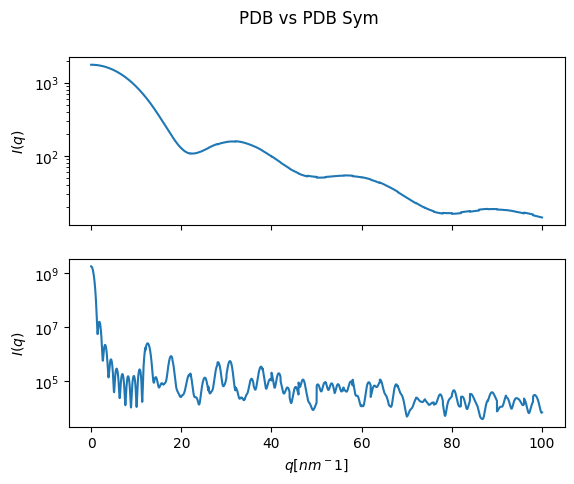

In [30]:
fig, (ax1, ax2) = plt.subplots(2, sharex=True)
fig.suptitle('PDB vs PDB Sym')
ax1.semilogy(q_60, I_q_PDB)
ax1.set_ylabel('$I(q)$')
ax2.semilogy(q_60, I_q_PDB_sym)
ax2.set_xlabel('$q [nm^-1]$')
ax2.set_ylabel('$I(q)$')
plt.show()

## g(r) module
Here we want to showcase the g_r module. First the helper functions:

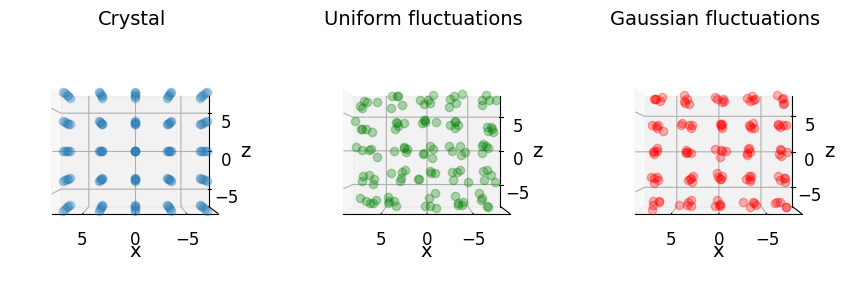

In [40]:
rand = 0.3

my_dol_name = r'../CF4_2.dol'
my_rand_dol_name = r'../CF4_rand.dol'
therm_dol_name = r'../CF4_therm.dol'

repx_2 = 5
repy_2 = 5
repz_2 = 5

a, alpha = 3.5, np.pi/2
cubic_lattice_2 = np.array([a, a, a, alpha, alpha, alpha])

my_cryst = g.build_crystal(cubic_lattice_2, repx_2, repy_2, repz_2, my_dol_name)
my_rand_cryst = g.build_crystal(cubic_lattice_2, repx_2, repy_2, repz_2, my_rand_dol_name, rand)
my_therm_cryst = g.thermalize(my_cryst, rand)
g.write_to_dol(therm_dol_name, my_therm_cryst)

xs, ys, zs = my_cryst[:, 0], my_cryst[:, 1], my_cryst[:, 2]
rand_xs, rand_ys, rand_zs = my_rand_cryst[:, 0], my_rand_cryst[:, 1], my_rand_cryst[:, 2]
therm_xs, therm_ys, therm_zs = my_therm_cryst[:, 0], my_therm_cryst[:, 1], my_therm_cryst[:, 2]

fig = plt.figure(figsize=plt.figaspect(0.45))
for i in range(3):
    ax = fig.add_subplot(1, 3, i+1, projection='3d')
    ax.view_init(0, 90, 0)
    ax.set_yticks([])
    if i == 0:
        ax.set_title('Crystal', size=14)
        ax.plot(xs, ys, zs, 'o', alpha=0.3)
    elif i == 1:
        ax.set_title('Uniform fluctuations', size=14)
        ax.plot(rand_xs, rand_ys, rand_zs, 'o', c='g', alpha=0.3)
    else:
        ax.set_title('Gaussian fluctuations', size=14)
        ax.plot(therm_xs, therm_ys, therm_zs, 'o', c='r', alpha=0.3)
    ax.tick_params(which='both', labelsize=12, color='k')
    ax.set_xlabel('x', size=14)
    # ax.set_ylabel('y', size=14)
    ax.set_zlabel('z', size=14)

Now we shall showcase the different ways g(r) can be calculated

In [ ]:
R = 1
rmax = 2.5
r_model, g_r_model, rho = g.g_r_from_model(my_dol_name, [repx_2, repy_2, repz_2], radius=R, r_min=R+.1, r_max=rmax)

r_model_therm, g_r_model_therm, rho_therm = g.g_r_from_model(filename, Lx, Ly, Lz, r_min=R,# radius=.3,r_max=rmax, file_triple=r'.\triple.dol', Number_for_average_conf=5, Number_for_average_atoms=5, thermal=1,
u=np.array([0.02, 0.02, 0.02]))
g.write_to_out(r'.\out\g_r_from_model_slow_therm.out', r_model_therm, g_r_model_therm)
N_mod_therm = simpson(rho_therm * g_r_model_therm[r_model_therm < 4] * 4 * np.pi * r_model_therm[r_model_therm
< 4]**2, r_model_therm[r_model_therm < 4])



r_simps, g_r_simps = g.g_r_from_s_q(qmod, sqmod, rho, r_min=R, r_max=rmax, type='Simpson')
g.write_to_out(r'.\out\g_r_from_s_q_simps.out', r_simps, g_r_simps)
N_simps = simpson(rho * g_r_simps[r_simps < 3.6] * 4 * np.pi * r_simps[r_simps < 3.6]**2, r_simps[r_simps < 3.6])

r_dst, g_r_dst = g.g_r_from_s_q(qmod, sqmod, rho, r_min=R, r_max=rmax, type='DST')
g.write_to_out(r'.\out\g_r_from_s_q_dst.out', r_simps, g_r_simps)
N_dst = simpson(rho * g_r_dst[r_dst < 3.6] * 4 * np.pi * r_dst[r_dst < 3.6]**2, r_dst[r_dst < 3.6])

# r_centered, g_r_centered = g.g_r_from_s_q(qmod, sqCent, rho, r_min=R, r_max=rmax, type='Simpson')
# g.write_to_out(r'.\out\g_r_from_centered.out', r_centered, g_r_centered)
# N_cent = simpson(rho * g_r_centered[r_centered < 3.6] * 4 * np.pi * r_centered[r_centered < 3.6]**2, r_centered[r_centered < 3.6])

print('N_mod = ', N_mod)
print('N_mod_therm = ', N_mod_therm)
print('N_simps = ', N_simps)
print('N_dst = ', N_dst)
# print('N_cent = ', N_cent)

q_simps, s_q_simps = g.s_q_from_g_r(r_model, g_r_model, rho, type='Simpson', q_max=qmax)
g.write_to_out(r'.\out\s_q_from_g_r_model_simps.out', q_simps, s_q_simps)
q_dst, s_q_dst = g.s_q_from_g_r(r_model, g_r_model, rho, type='DST', q_max=qmax)
g.write_to_out(r'.\out\s_q_from_g_r_model_dst.out', q_dst, s_q_dst)
q_g, s_q_g = g.s_q_from_g_r(r_simps, g_r_simps, rho, q_max=qmax)
g.write_to_out(r'.\out\s_q_from_g_r_simps.out', q_g, s_q_g)

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
# plt.figure()
ax1.plot(r_model, g_r_model, label='Model', lw=3)
# ax1.set_xlabel('r [nm]', size=14)
ax1.set_ylabel('$\\rho(r)/\\rho_{b}$', size=14)
# ax1.grid()
ax1.legend(fontsize=14)

ax2.plot(r_simps, g_r_simps, label='Simpson', lw=3)
ax2.plot(r_dst, g_r_dst, label='DST', lw=3)
# plt.title('Radial Distribution Function', size=14)
ax2.set_xlabel('r [nm]', size=14)
ax2.set_ylabel('$\\rho(r)/\\rho_{b}$', size=14)
# ax2.grid()
ax2.legend(fontsize=14, loc=2)

# ax3.plot(r_model, g_r_model, label='Model', lw=3)
# ax3.plot(r_centered, g_r_centered, label='Centered', lw=3)
# ax3.set_xlabel('r [nm]', size=14)
# ax3.set_ylabel('$\\rho(r)/\\rho_{b}$', size=14)
# ax3.grid()
# ax3.legend(fontsize=14)
# ax3.ticklabel_format(style='scientific', axis='y', scilimits=(0, 0))

plt.savefig(r'.\Pics\RDF_Model_VS_DST.png')
plt.close()

fig, (ax1, ax2) = plt.subplots(2, sharex=True)
ax1.plot(r_model_therm, g_r_model_therm, label='With fluctuations', lw=3)
ax1.plot(r_model, g_r_model, label='With radius', lw=3)
ax1.set_ylabel('$\\rho(r)/\\rho_{b}$', size=14)
ax1.legend(fontsize=14, loc='upper left')

# ax2.plot(r_model_therm, g_r_model_therm, label='Model w. fluctuations', lw=3)
ax2.plot(r_simps, g_r_simps, label='Simpson', lw=3)
ax2.plot(r_dst, g_r_dst, label='DST', lw=3)
ax2.set_xlabel('r [nm]', size=14)
ax2.set_ylabel('$\\rho(r)/\\rho_{b}$', size=14)
ax2.legend(fontsize=14, loc=2)

plt.savefig(r'.\Pics\RDF_Model_VS_DST_fluct.png')
plt.close()
# plt.figure()
# plt.plot(r_model, g_r_model, label='Model', lw=3)
# plt.plot(r_centered, g_r_centered, label='centered', lw=3)
# # plt.plot(r_simps, g_r_simps, label='Simpson', lw=3)
# # plt.title('Radial Distribution Function - comparison between ways')
# plt.xlabel('r [nm]', size=14)
# plt.ylabel('$\\rho(r)/\\rho_0$', size=14)
# plt.grid()
# plt.legend(fontsize=14)
# plt.savefig(r'.\Pics\RDF_comparison.png')
# plt.close()

plt.figure()
plt.semilogy(qmod, sqmod, label='Model', lw=3)
# plt.semilogy(q_dst, s_q_dst, label='Model - DST', lw=3)
plt.semilogy(q_simps, s_q_simps, label='Model - Simpson', lw=3)
plt.semilogy(q_g, s_q_g, label='S(q) to g(r) to S(q) - Simpson', lw=3)
# plt.title('Structure Factor from RDF', size=14)
plt.xlabel('q $[nm^{-1}]$', size=14)
plt.ylabel('S(q) [a.u.]', size=14)
# plt.grid()
plt.legend(fontsize=14, loc='upper right')
plt.savefig(r'.\Pics\s_q_from_g_r.png')
plt.close()

return